In [39]:
#import packages
import os
import cv2
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moviepy.editor
import IPython.display
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline
%matplotlib qt
out_dir='output_images/'

# camera calibration

Processing image camera_cal/calibration5.jpg
Processing image camera_cal/calibration4.jpg
Processing image camera_cal/calibration6.jpg
Processing image camera_cal/calibration7.jpg
Processing image camera_cal/calibration3.jpg
Processing image camera_cal/calibration2.jpg
Processing image camera_cal/calibration1.jpg
Processing image camera_cal/calibration20.jpg
Processing image camera_cal/calibration19.jpg
Processing image camera_cal/calibration18.jpg
Processing image camera_cal/calibration15.jpg
Processing image camera_cal/calibration14.jpg
Processing image camera_cal/calibration16.jpg
Processing image camera_cal/calibration17.jpg
Processing image camera_cal/calibration13.jpg
Processing image camera_cal/calibration12.jpg
Processing image camera_cal/calibration10.jpg
Processing image camera_cal/calibration11.jpg
Processing image camera_cal/calibration9.jpg
Processing image camera_cal/calibration8.jpg


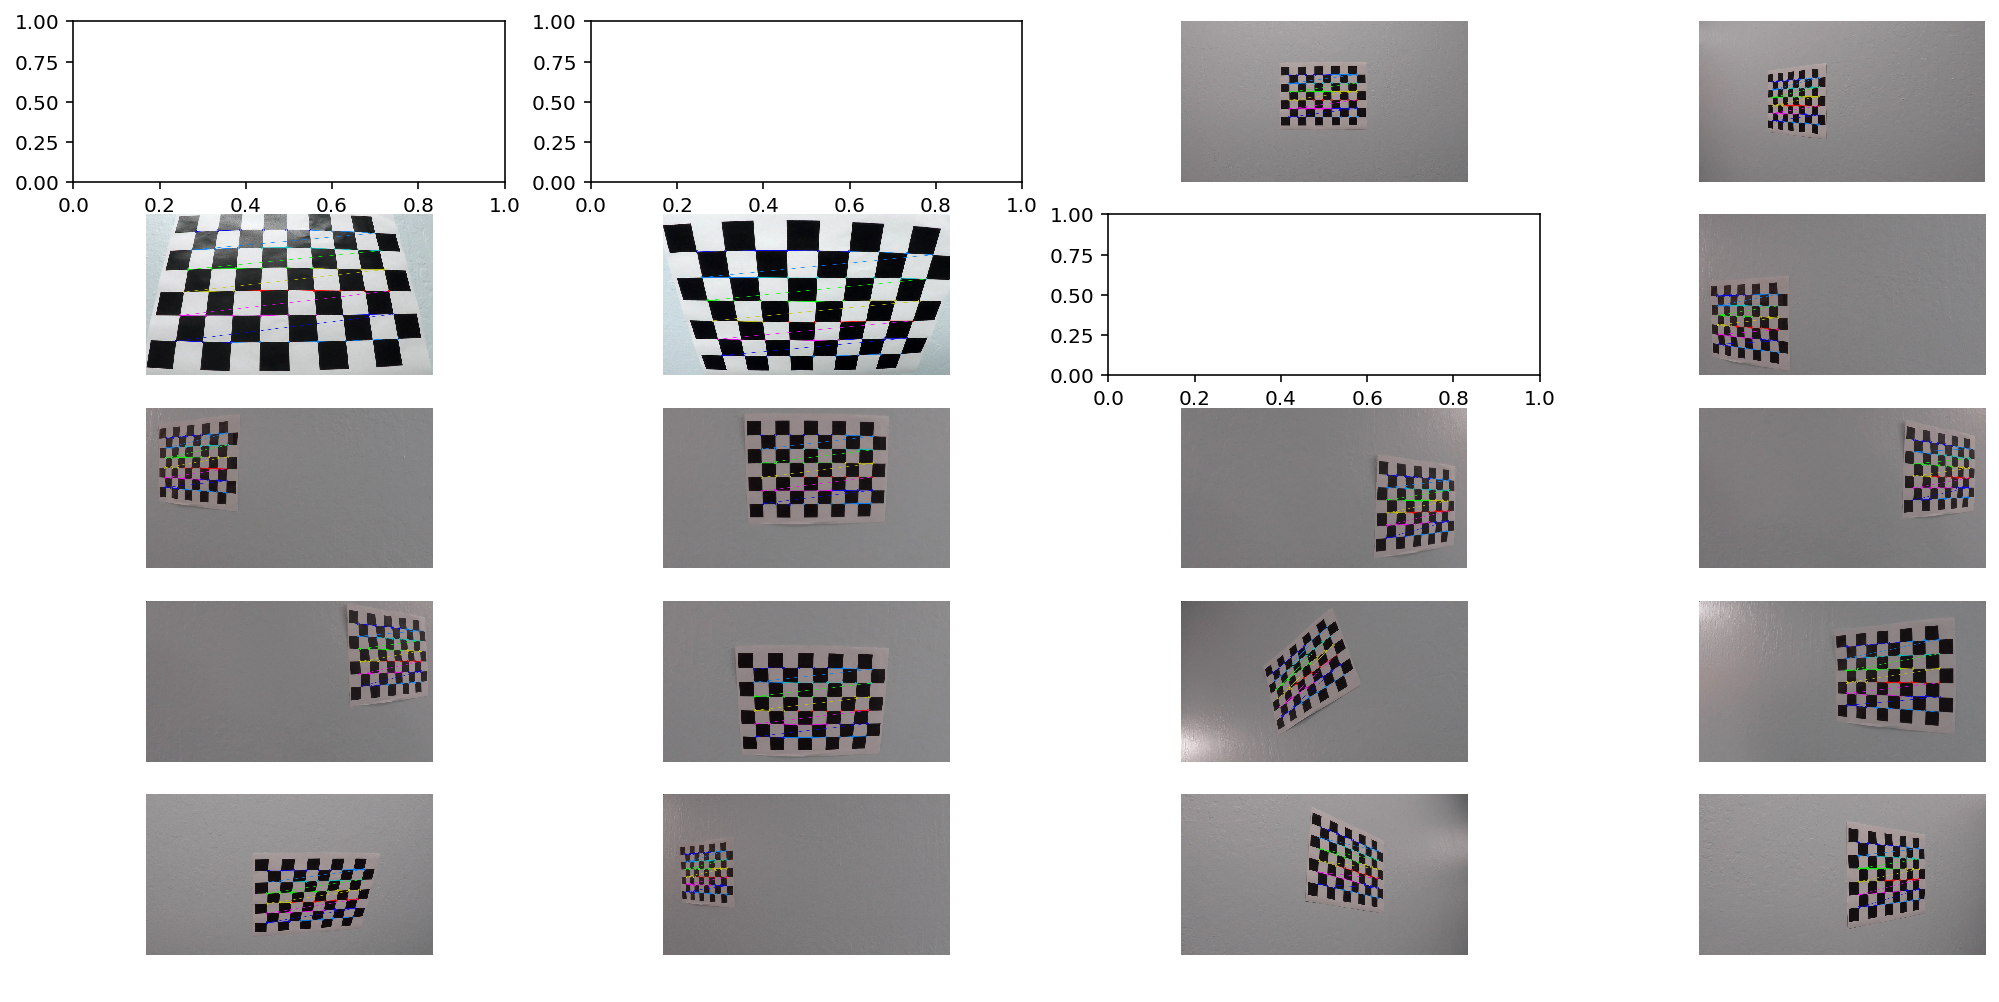

In [41]:
#calibrate the camera
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4,figsize = (20,10))
#fig.subplots_adjust(hspace = 0.2, wspace=0.01)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    print("Processing image %s" %str(fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #print("ret = ", ret)
    #axs[idx].axis('off')
    
    # If found, add object points, image points
    if ret == True:      
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (ny,nx), corners, ret)
        img_name = os.path.split(fname)[1]
        write_name = out_dir +'corners_found'+ '_' +img_name
        cv2.imwrite(write_name, img)
        axs[idx].axis('off')
        axs[idx].imshow(img)
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

Text(0.5, 1.0, 'undistort Image')

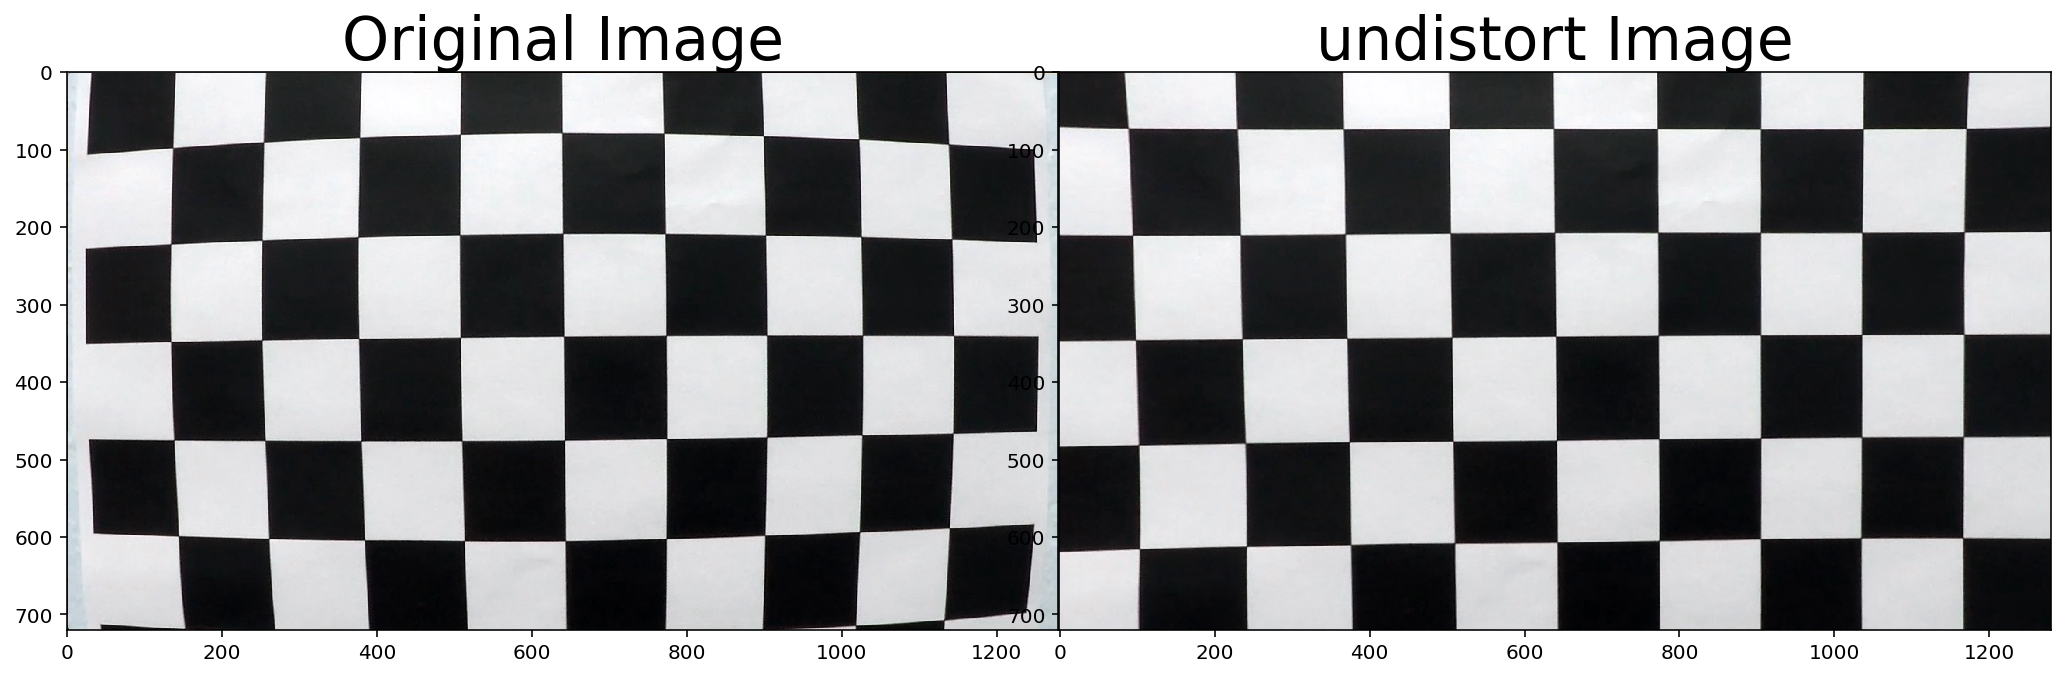

In [43]:
#Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# calibrate the camera by given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
t_undist = cv2.undistort(img, mtx, dist, None, mtx)
#undist = cv2.undistort(img, mtx, dist, None, mtx)
undis_name  = out_dir+'undistort_chessboard'
plt.imsave(undis_name,t_undist)

fig, axs = plt.subplots(1,2, figsize = (20,10))
fig.subplots_adjust(hspace = 0.2, wspace = 0.001)
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('Original Image', fontsize=30)
axs[1].imshow(t_undist)
axs[1].set_title('undistort Image', fontsize=30)

In [44]:
#save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_dist_pickle.p", "wb"))

In [45]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [46]:
#undistort image by camera calibration matrix 
def undistort(img, mtx = mtx, dist = dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

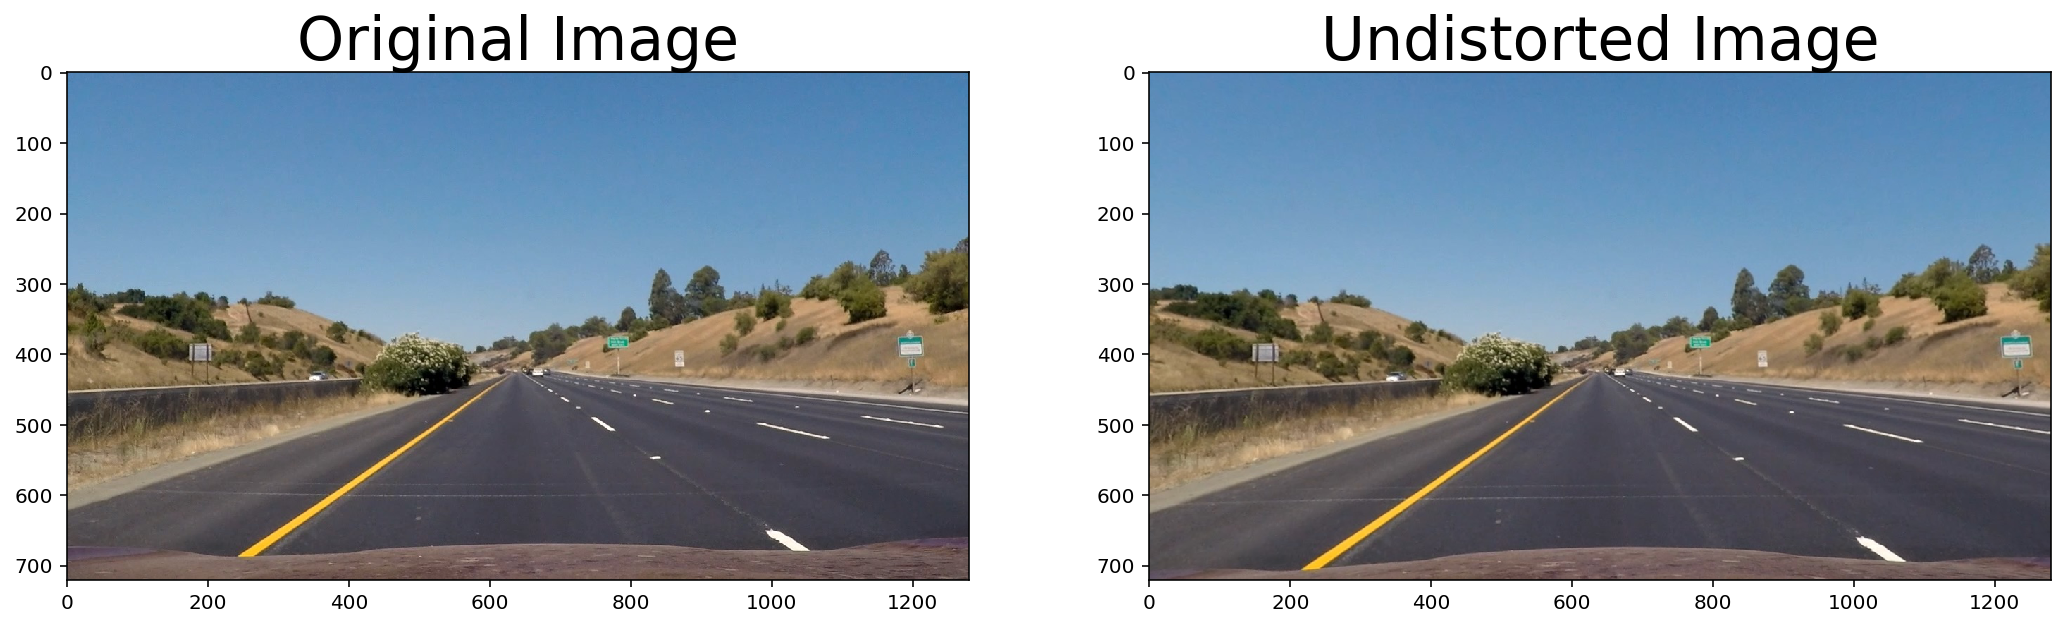

In [48]:
#test images
img = plt.imread('test_images/straight_lines1.jpg')
dst = undistort(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.imshow(dst)

#images = glob.glob('test_images/*.jpg')

#fig, axs = plt.subplots(4,2,figsize = (25,20))
#fig.subplots_adjust(hspace = 0.2, wspace = 0.0001)
#axs = axs.ravel()

#for idx, fname in enumerate(images):
#    img = plt.imread(fname)
#    dst = undistort(img)
#    image_name = os.path.split(fname)[1]
#    write_name = out_dir + 'undistorted_'+ image_name
#    cv2.imwrite(write_name, dst)
#    axs[idx].axis('off')
#    axs[idx].imshow(img)

# Sobel

In [49]:
#color and gradient
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    #print("size of binary is", binary.shape)
    #binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

Text(0.5, 1.0, 'Channels')

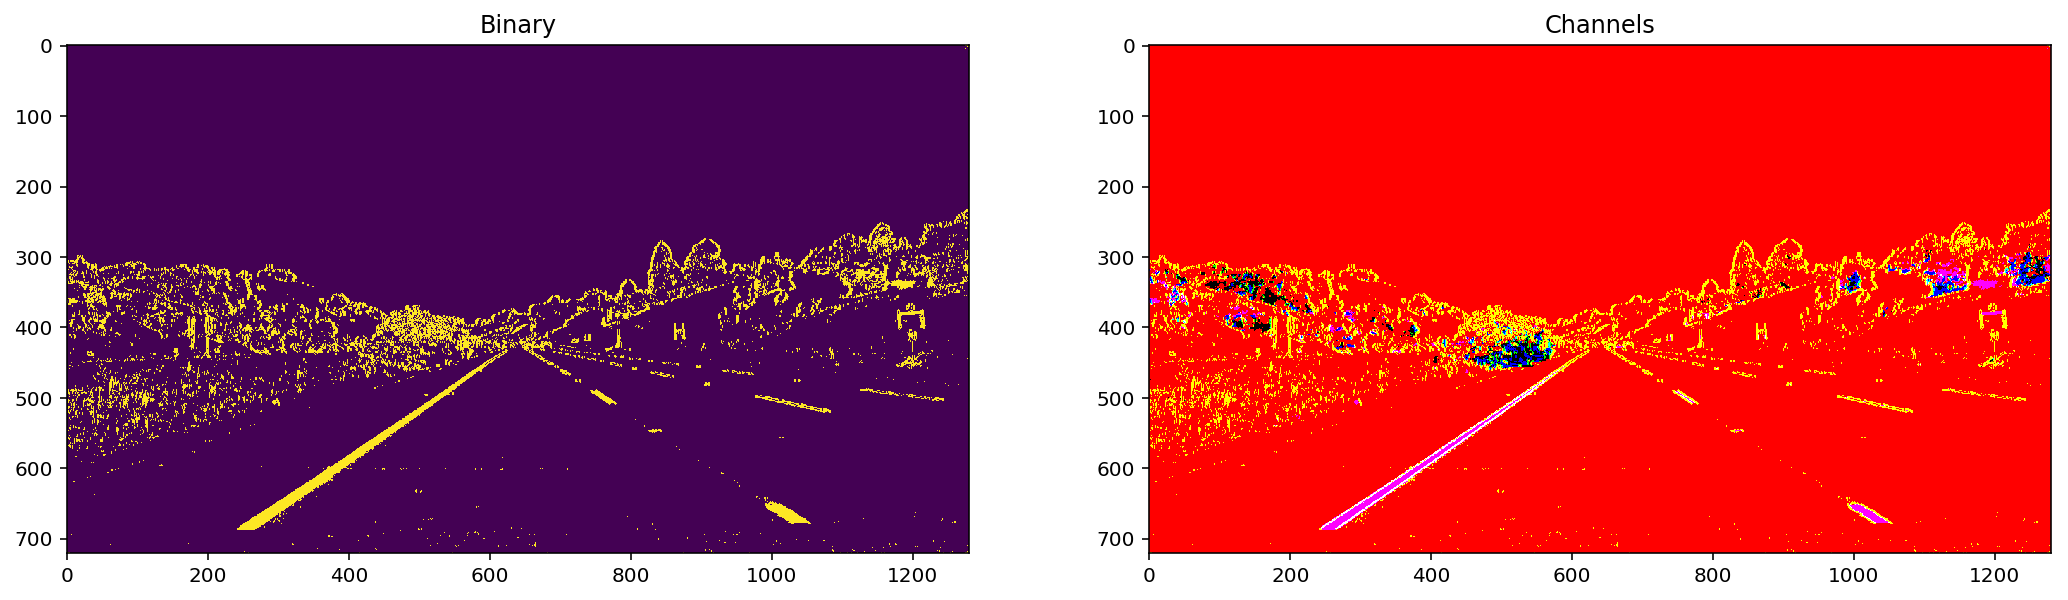

In [50]:
#test image
img = plt.imread('test_images/straight_lines1.jpg')

binary,channels = binarize(img)

#save binary and channels
binary_name = out_dir+'binary.jpg'
cv2.imwrite(binary_name, binary)
plt.imsave(out_dir+'binary.jpg',binary)
channel_name = out_dir+'channels.jpg'
cv2.imwrite(channel_name, channels)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2,figsize = (25,20))
ax1.imshow(binary)
ax1.set_title('Binary')
ax2.imshow(channels)
ax2.set_title('Channels')

# Perspective Transform

In [51]:
def perspective_trans(img):
    
    #img_size = (img.shpae[1], img.shape[0])
     # define source and destination points for transform
    src = np.float32([(190,720),
                  (589,460), 
                  (698,460), 
                  (1145,720)])
    dst = np.float32([(340,720),
                  (340,0),
                  (995,0),
                  (995,720)])
    #compute the perspective transform, which is a matrix that's returned by the function getPerspectiveTransform
    warp_M = cv2.getPerspectiveTransform(src,dst)
    #could also get the inverse perspective transform to unwarp
    warp_Minv = cv2.getPerspectiveTransform(dst, src)
    
    #apply the transform M to original image to get the wraped image
    warped = cv2.warpPerspective(img, warp_M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, warp_M, warp_Minv

Text(0.5, 1.0, 'Warped')

<Figure size 864x576 with 0 Axes>

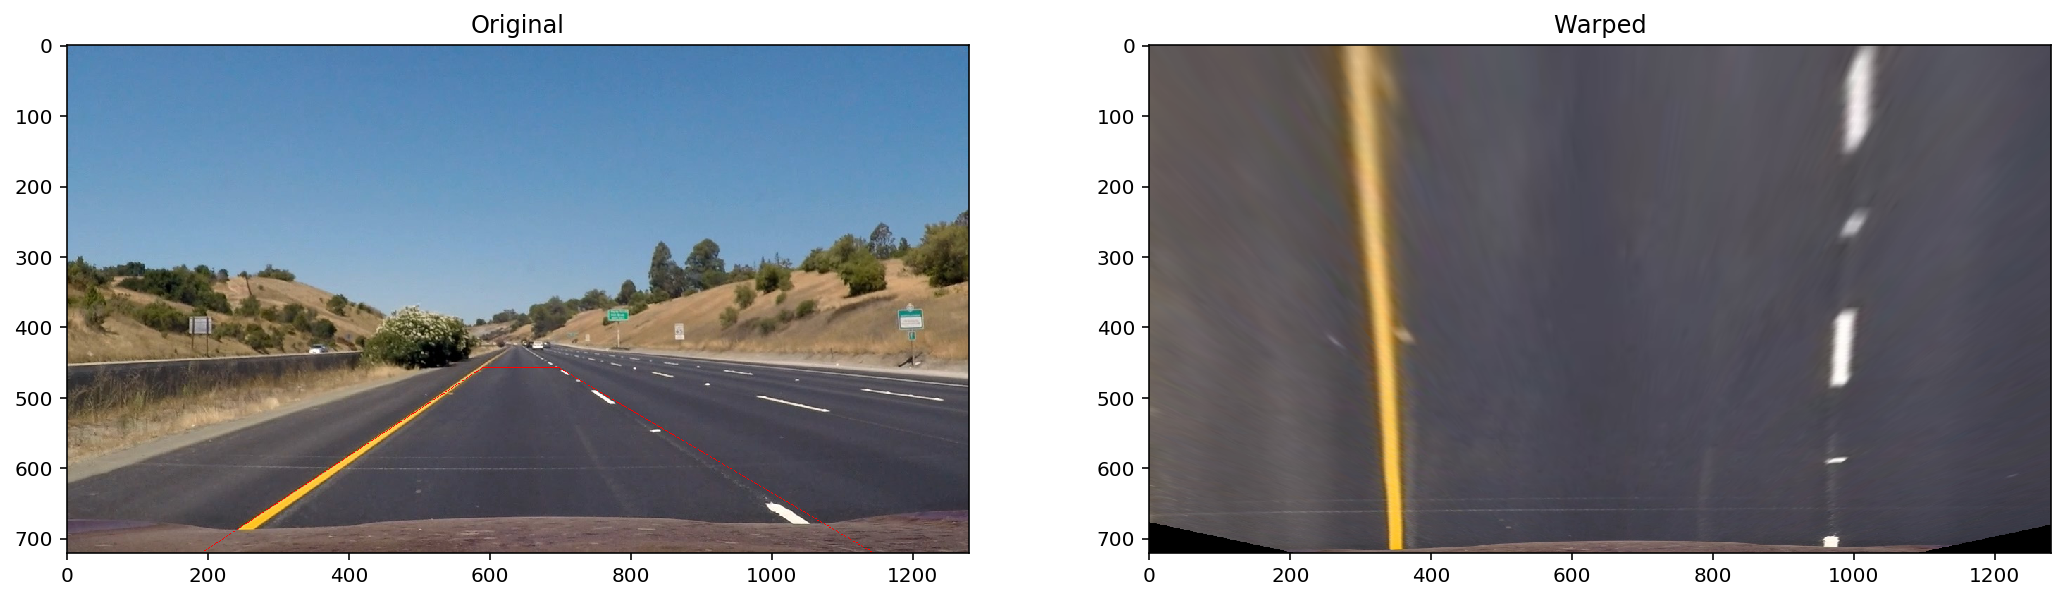

In [52]:
#perspective transform on test images
img = plt.imread('test_images/straight_lines1.jpg')

corners = np.float32([(190,720),(589,457), (698,457), (1145,720)])
ud_img = undistort(img)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped,wrap_M, wrap_MinV = perspective_trans(ud_img) 
plt.imsave(out_dir+'straight_lines1.jpg',img)
plt.imsave(out_dir+'straight_lines1_warped.jpg',warped)



# Plot the result
plt.figure()
f,(ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))

ax1.imshow(img)
ax1.set_title('Original')

ax2.imshow(warped)
ax2.set_title('Warped')



In [53]:
#apply an image mask, just keep the region we interest
def region_of_interest(img):
   
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)
    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [54]:
#define perspective transform pipeline
def warp_pipeline(img):
    undist = undistort(img)    
    warped,warp_M, warp_MinV = perspective_trans(undist)
    warped = region_of_interest(warped)
    return warped

In [55]:
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,channels  = binarize(undist)
    #print("size after binarize: ", binary.shape)
    #print("channels is", channels)
    warped,warp_M, warp_Minv  = perspective_trans(binary)
    result= region_of_interest(warped)
    return result 

Text(0.5, 1.0, 'Binary warped out')

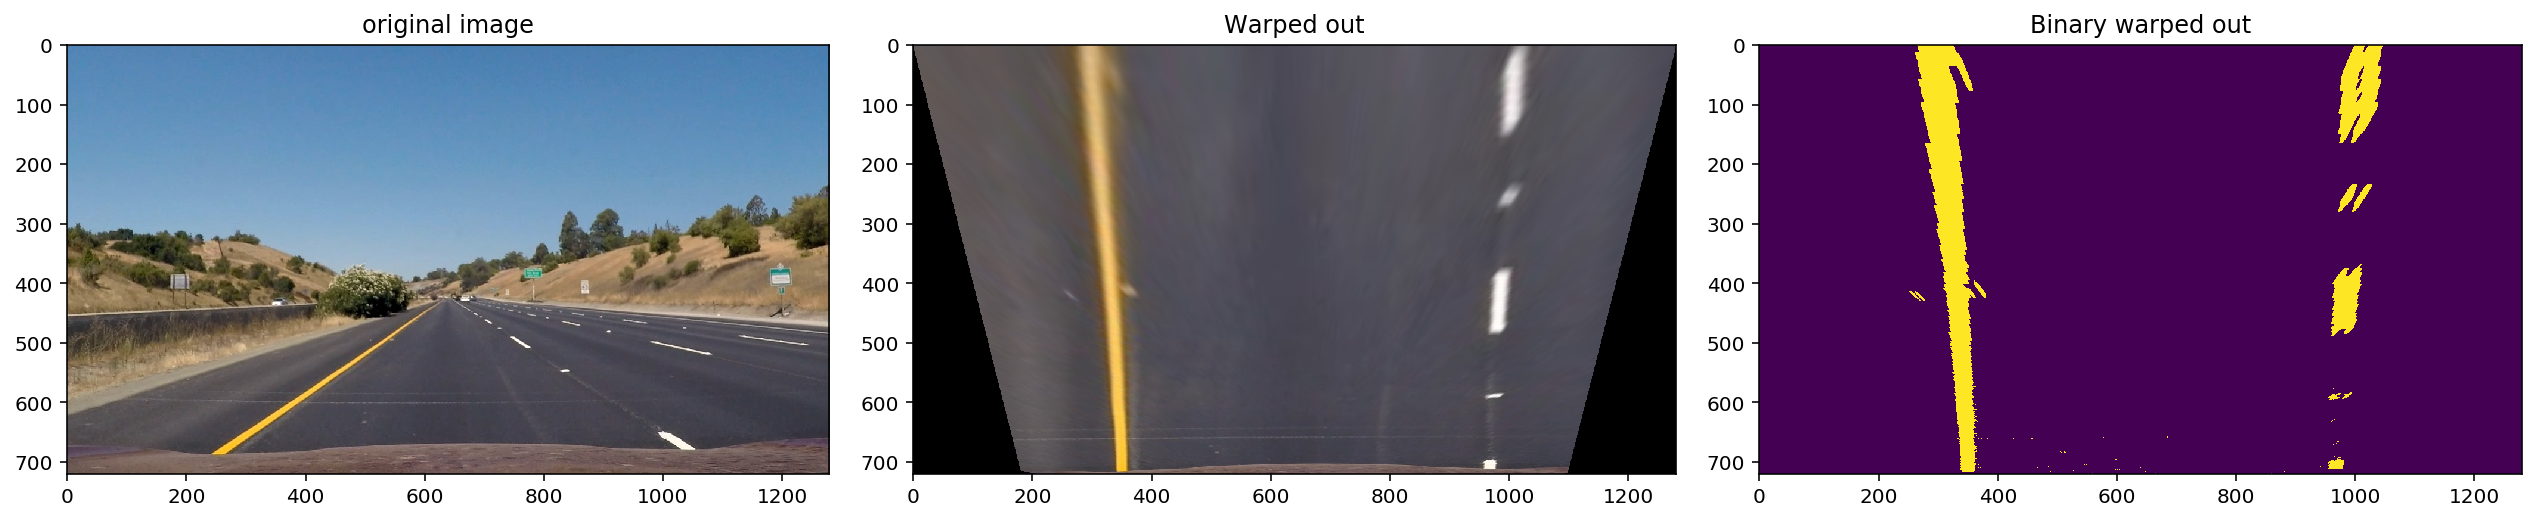

In [58]:
#test warp_pipeline and warp_binarize_pipeline
img = plt.imread('test_images/straight_lines1.jpg')
warp_out = warp_pipeline(img)
binary_warped_out = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_out.jpg',warp_out)
plt.imsave(out_dir+'binary_warped_out.jpg',binary_warped_out)

# Plot the result
f, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('original image')

ax2.imshow(warp_out)
ax2.set_title('Warped out')

ax3.imshow(binary_warped_out)
ax3.set_title('Binary warped out')

In [59]:
# sliding window
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    #print("size of binary_warped_out is:", binary_warped.shape)
  
    img_half=binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(img_half, axis=0)
    plt.plot(histogram)
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #print("shape of histogram is",  histogram.shape)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #print("size of out_img is", out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:histogram.shape[0]]) + midpoint
    
    #print("midpoint =", midpoint)
    #print("leftx_base = ", leftx_base)
    #print("rightx_base = ", rightx_base)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    #print("window_height = ", window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    #get the index of nonzero
    nonzero = binary_warped.nonzero() 
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []
    # Step through the windows one by one
    for window in range(nwindows):
        #print('window =', window)
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print("win_y_low = ", win_y_low)
        #print("win_y_high = ", win_y_high)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #print("win_xleft_low =", win_xleft_low)
        #print("win_xleft_high =", win_xleft_high)
        #print("win_xright_low = ", win_xright_low)
        #print("win_xright_high =", win_xright_high)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2) 
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print("good_left_inds = ", good_left_inds)
        #print("good_right_inds =", good_right_inds)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    

    return leftx, lefty, rightx, righty, out_img


In [60]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = (0, 0, 255)
    out_img[righty, rightx] = (255, 0, 0)
    #print("size of Lane_pts is", Lane_pts)
    #Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return out_img, left_fit, right_fit,left_fitx, right_fitx, ploty


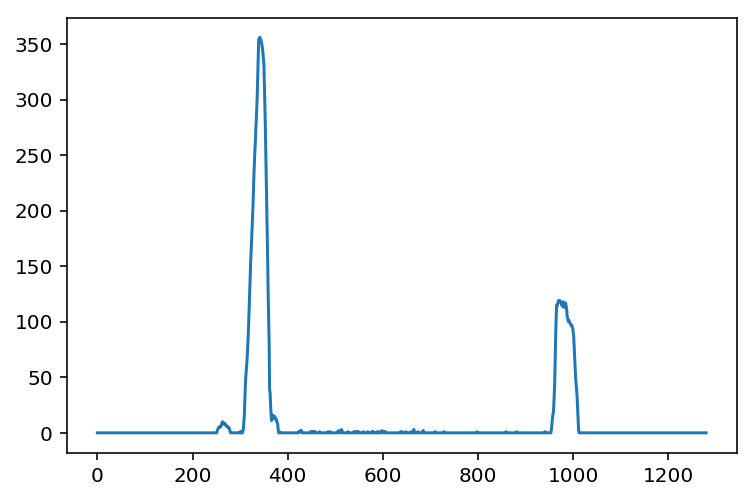

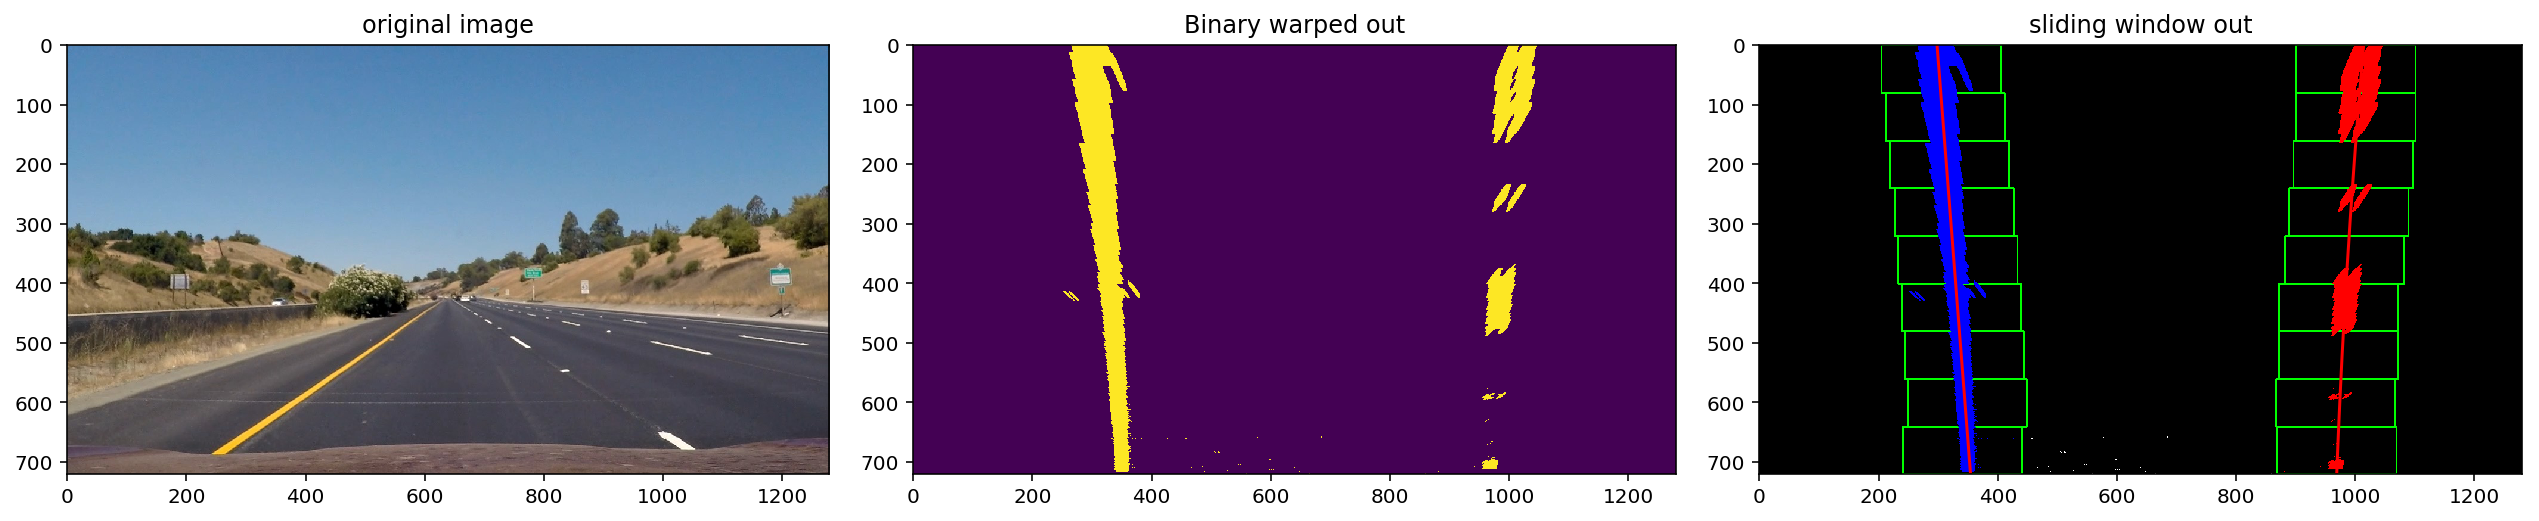

In [62]:
out_img,left_fit, right_fit, left_fitx, right_fitx,ploty = fit_polynomial(binary_warped_out)

# Plot the result
f, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('original image')

ax2.imshow(binary_warped_out)
ax2.set_title('Binary warped out')

ax3.imshow(out_img)
ax3.set_title('sliding window out')
ax3.plot(left_fitx, ploty, color='red')
ax3.plot(right_fitx, ploty, color='red')


In [63]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty



In [64]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty



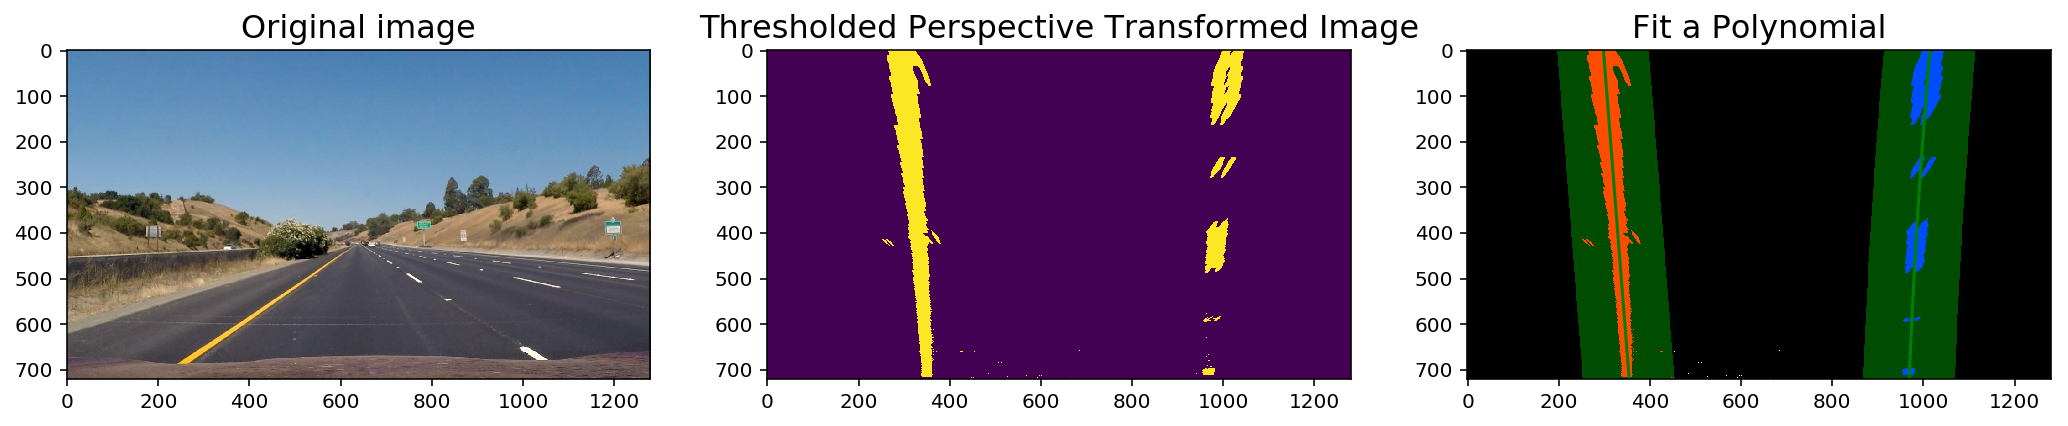

In [65]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
Poly, left_fitx, right_fitx, ploty = search_around_poly(binary_warped_out, left_fit, right_fit)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.set_title('Original image', fontsize=16)
ax1.imshow(img)
ax2.set_title('Thresholded Perspective Transformed Image', fontsize=16)
ax2.imshow(binary_warped_out)
ax3.set_title('Fit a Polynomial', fontsize=16)
ax3.imshow(Poly)
# Plots the left and right polynomials on the lane lines
ax3.plot(left_fitx, ploty, color='green')
ax3.plot(right_fitx, ploty, color='green')
#ax3.imshow(result)


In [67]:
#determine the curvature
def measure_curvature_real(img_shape, left_fitx, right_fitx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2

    ## Car position with respect to the lane
    car_pos = (left_fitx[-1] + right_fitx[-1])/2
    
    center_offset = (mid_imgx - car_pos) * xm_per_pix
    
    return left_curverad, right_curverad, center_offset

In [68]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#detecting the curvature
left_curverad, right_curverad, center_offset = measure_curvature_real(binary_warped_out.shape, left_fitx, right_fitx, ploty)
print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')
print ('Car offset from center:', center_offset, 'm.')

Left line curvature: 799694.3157143468 m
Right line curvature: 4882.472655687253 m
Car offset from center: -0.11433324064545461 m.


In [69]:
#Warp the detected lane boundaries back onto the original image.
def draw_lane(undist, binary_warp, left_fitx, right_fitx, ploty, Minv, lane_mage='', show=False):
    #print("size of left_fitx is", left_fitx.shape)
    #print("size of ploty is", ploty.shape)
    # Create an image to draw the lines on
    binary_warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_persp = np.dstack((binary_warp_zero, binary_warp_zero, binary_warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_persp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    inv_persp = cv2.warpPerspective(color_persp, Minv, (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    lane = cv2.addWeighted(undist, 1, inv_persp, 0.3, 0)

    #if lane_image != '':
     #   plt.imsave(lane_image, lane)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.set_title('Undistorted image', fontsize=16)
        ax1.imshow(undist)
        ax2.set_title('Detected Lane', fontsize=16)
        ax2.imshow(lane)
    
    return lane

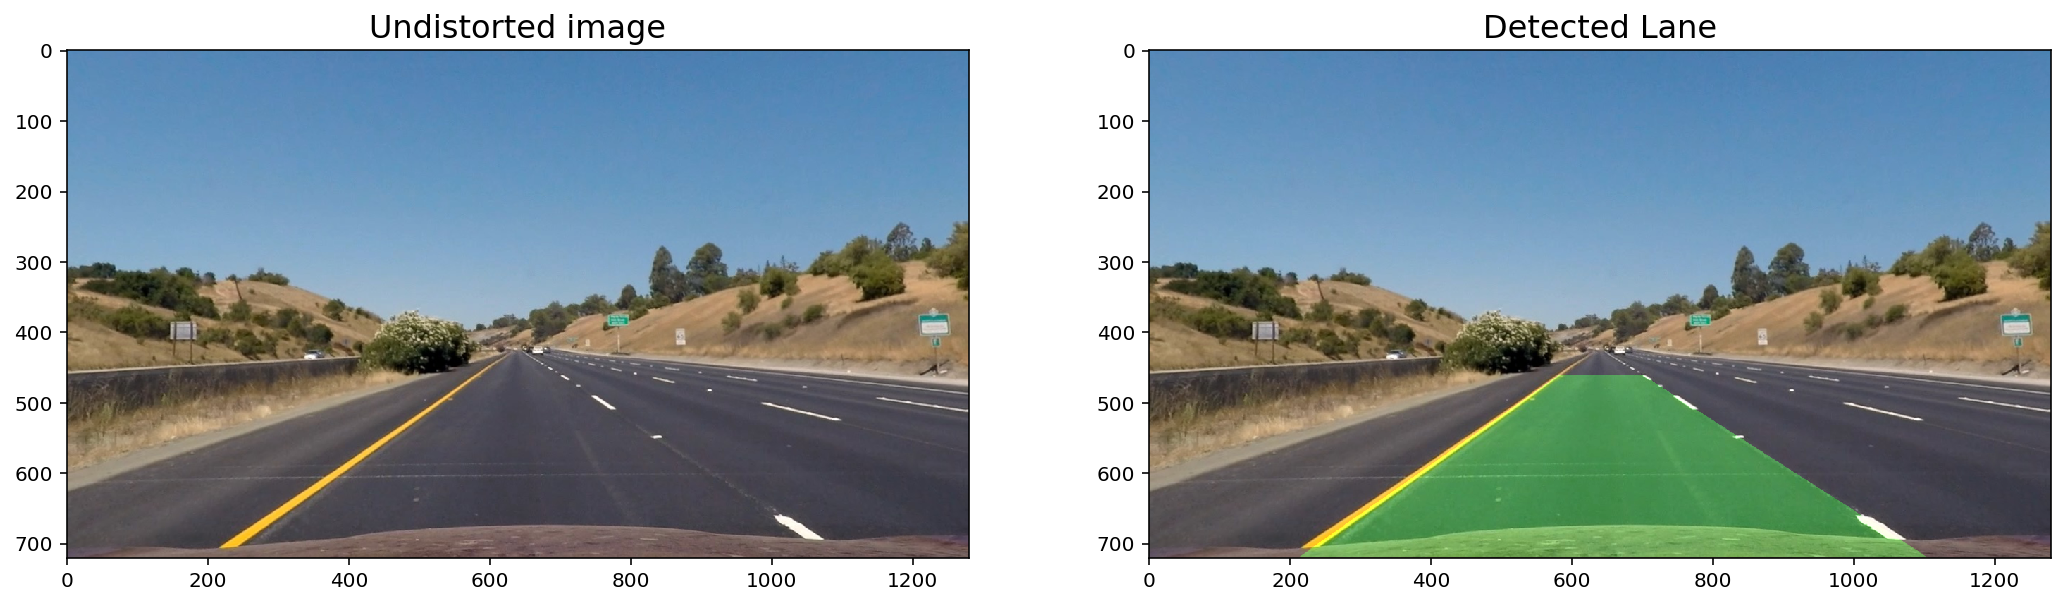

In [70]:
LANE_IMAGE = 'output_images/straight_lines1_lane.jpg'
undist = undistort(img)
lane = draw_lane(undist, binary_warped_out, left_fitx, right_fitx, ploty, wrap_MinV, show=True)

In [ ]:
#process the test images

#read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
#first or not
global First
First = True

#define the pipline for image process
def process_image(img):
    
    #global counter
    #global ref_left 
    #global ref_right
    #global left_fit
    #global right_fit
    #1. undistort image by camera calibration matrix     
    img_undist = undistort(img)
    #print("111")
    #2. color and gradient
    img_binary,img_channels  = binarize(img_undist)
    #print("222")
    #3. Perspective transform
    img_warped,warp_M, warp_Minv  = perspective_trans(img_binary)
    #print("333")
    #4. region of interest
    binary_warped_out = region_of_interest(img_warped)
    #print("444")
    #5. Detect lanes and return fit curves
    if First == True:
        out_img,left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_out)
        First == False
        #print("551")
    else:
        out_img, left_fitx, right_fitx, ploty = search_around_poly(binary_warped_out, left_fit, right_fit)
        #print("552")
     #6. calculate curvature and center   
    left_curverad, right_curverad, center_offset = measure_curvature_real(binary_warped_out.shape, left_fitx, right_fitx, ploty)
    #print("666")
    #7. Warp back to original and merge with image 
    lane = draw_lane(img_undist, binary_warped_out, left_fitx, right_fitx, ploty, wrap_MinV, show=False)
    #print("777")
    #8. Write curvature and center in image
    lane_with_curvature = lane.copy()
    TextL = "Left curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right curvature: " + str(int(right_curverad))+ " m"
    TextC = "Center offset: " + str(round( center_offset,2)) + "m"
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(lane_with_curvature, TextL, (30,40), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(lane_with_curvature, TextR, (30,70), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(lane_with_curvature, TextC, (30,100), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    #print("888")
  
    
    #save images
    #undist_name = out_dir + 
    #binary_name = out_dir+'binary.jpg'
    #cv2.imwrite(binary_name, binary)
    #plt.imsave(out_dir+'binary.jpg',binary)
    #channel_name = out_dir+'channels.jpg'
    #cv2.imwrite(channel_name, channels)
    
    return img_undist, img_binary, img_channels, img_warped,out_img, left_curverad, right_curverad,lane, lane_with_curvature


In [ ]:
img = plt.imread('test_images/straight_lines1.jpg')
img_undist, img_binary, img_channels, img_warped,out_img, left_curverad, right_curverad,lane, lane_with_curvature = process_image(img)
#display the images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 10))
fig.subplots_adjust(hspace = 0.3, wspace=0.01)
ax1.set_title('Original image')
ax1.imshow(img)
ax2.set_title('Undistort image')
ax2.imshow(img_undist)
ax3.set_title('Binarized image')
ax3.imshow(img_binary)
ax4.set_title('Bird view')
ax4.imshow(img_warped)
ax5.set_title('Region limited')
ax5.imshow(binary_warped_out)
ax6.set_title('Detected Lane')
ax6.imshow(out_img)
ax7.set_title('merge with image')
ax7.imshow(lane)
ax8.set_title('Curvature')
ax8.imshow(lane_with_curvature)

In [ ]:
#process the test images
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    img = plt.imread(fname)
    #get the name of images
    name = str(fname[12:])
    
    # image names
    undis_name  = out_dir+'undistort_'+name
    binary_name = out_dir + 'binary_' + name
    channels_name = out_dir + 'channels_'+name
    warped_name = out_dir + 'warped_' + name
    det_lane_name = out_dir +'detected_lane_' + name
    lane_with_cur = out_dir +'lane_with_curvature_' + name
    #process the image
    LANE_IMAGE = 'det_lane_name'
    img_undist, img_binary, img_channels, img_warped,out_img, left_curverad, right_curverad,lane, lane_with_curvature = process_image(img)
    
      #display the images
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 10))
    fig.subplots_adjust(hspace = 0.3, wspace=0.01)
    ax1.set_title('Original image')
    ax1.imshow(img)
    ax2.set_title('Undistort image')
    ax2.imshow(img_undist)
    ax3.set_title('Binarized image')
    ax3.imshow(img_binary)
    ax4.set_title('Bird view')
    ax4.imshow(img_warped)
    ax5.set_title('Region limited')
    ax5.imshow(binary_warped_out)
    ax6.set_title('Detected Lane')
    ax6.imshow(out_img)
    ax7.set_title('merge with image')
    ax7.imshow(lane)
    ax8.set_title('Curvature')
    ax8.imshow(lane_with_curvature)
    
    #save images
    plt.imsave(undis_name,img_binary)
    plt.imsave(binary_name,img_undist)
    plt.imsave(channels_name,img_channels)
    plt.imsave(warped_name,img_warped)
    plt.imsave(det_lane_name,lane)
    plt.imsave(lane_with_cur,lane_with_curvature)

print("finished")
    

In [ ]:
def process_video_image(img):
    
    #global counter
    #global ref_left 
    #global ref_right
    #global left_fit
    #global right_fit
    #1. undistort image by camera calibration matrix     
    img_undist = undistort(img)
    #print("111")
    #2. color and gradient
    img_binary,img_channels  = binarize(img_undist)
    #print("222")
    #3. Perspective transform
    img_warped,warp_M, warp_Minv  = perspective_trans(img_binary)
    #print("333")
    #4. region of interest
    binary_warped_out = region_of_interest(img_warped)
    #print("444")
    #5. Detect lanes and return fit curves
    if First == True:
        out_img,left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_out)
        First == False
        #print("551")
    else:
        out_img, left_fitx, right_fitx, ploty = search_around_poly(binary_warped_out, left_fit, right_fit)
        #print("552")
     #6. calculate curvature and center   
    left_curverad, right_curverad, center_offset = measure_curvature_real(binary_warped_out.shape, left_fitx, right_fitx, ploty)
    #print("666")
    #7. Warp back to original and merge with image 
    lane = draw_lane(img_undist, binary_warped_out, left_fitx, right_fitx, ploty, wrap_MinV, show=False)
    #print("777")
    #8. Write curvature and center in image
    lane_with_curvature = lane.copy()
    TextL = "Left curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right curvature: " + str(int(right_curverad))+ " m"
    TextC = "Center offset: " + str(round( center_offset,2)) + "m"
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(lane_with_curvature, TextL, (30,40), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(lane_with_curvature, TextR, (30,70), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(lane_with_curvature, TextC, (30,100), fontFace, fontScale,(255,0,0), thickness,  lineType = cv2.LINE_AA)
    #print("888")
  
    
    #save images
    #undist_name = out_dir + 
    #binary_name = out_dir+'binary.jpg'
    #cv2.imwrite(binary_name, binary)
    #plt.imsave(out_dir+'binary.jpg',binary)
    #channel_name = out_dir+'channels.jpg'
    #cv2.imwrite(channel_name, channels)
    
    return lane_with_curvature


In [ ]:
#process the video
#Create video file pipeline
First = True
output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
type(clip1)
print("clip1 is:", clip1)
#out_clip = process_image(clip1.f1_image)
out_clip = clip1.fl_image(process_video_image) 
%time out_clip.write_videofile(output, audio=False)
